<a href="https://colab.research.google.com/github/TobiasSunderdiek/hyperparameter-tuning-with-tune/blob/master/predicting_bike_sharing_data_with_tune_for_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting bike sharing data with tune for hyperparameter tuning


This notebook is based on the udacity deep learning nanodegree project for predicting bike sharing data, which can be found here:

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb

I use the udacity implementation as a starting point for a self-learning project in which I try to build a variation where the model is a fcn and the hyperparameter tuning is done with tune[1].

[1] https://ray.readthedocs.io/en/latest/tune.html

## Prepare for using tune
For use in colab, pyarrow has to be uninstalled.

Additionally, clean-up log dir for tune logs.

In [1]:
# preparing for using tune
!pip install ray
!pip uninstall -y pyarrow
# cleanup tune log dir if exists
!rm -rf tune_logs

## Loading dataset from github
The original dataset is located here:

https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

which originaly came from [1].

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

In [2]:
# Fetch a single file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1129k  100 1129k    0     0  2521k      0 --:--:-- --:--:-- --:--:-- 2515k


In [3]:
import pandas as pd

rides = pd.read_csv("/content/hour.csv")
rides_origin = rides
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Convert data
- hot-encode categorical features *season*, *weathersit*, *mnth*, *hr*, *weekday* and drop origin of this features
- drop fields *instant*, *dteday*, *atemp* and *workingday* as in the udacity project
- additionally drop fields *casual* and *registered*, focus on overall output *cnt*
- shift and scale continuous features *cnt*, *temp*, *hum*, *windspeed* so they have zero mean and standard deviation of 1

In [4]:
for feature in ['season', 'weathersit', 'mnth', 'hr', 'weekday']:
  hot_encoded_features = pd.get_dummies(rides[feature], prefix=feature, drop_first=False)
  rides = pd.concat([rides, hot_encoded_features], axis=1)
  rides = rides.drop(feature, axis=1)
rides = rides.drop(['instant', 'dteday', 'atemp', 'workingday', 'casual', 'registered'], axis=1)

feature_scaling_store = {}

for feature in ['cnt', 'temp', 'hum', 'windspeed']:
  mean, std = rides[feature].mean(), rides[feature].std()
  feature_scaling_store[feature] = [mean, std]
  rides.loc[:, feature] = (rides[feature] - mean) / std

rides.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Split into training,  testing and validation set
The data consists of entries of how many bikes are rented at one specific hour of the day. The total number of entries in the hour.csv is 17.379, which means divided by 24 there are datapoints for approximatly 724 days.

The last 21 days (3%) are used as testing data.

Of the remaining days, 60 days (8.5%) are used as validation data.

The training data consists of 643 days.

In [0]:
test_data = rides[-21*24:]
rides = rides[:-21*24]

validation_data = rides[-60*24:]
rides = rides[:-60*24]

train_data = rides

target_fields = ['cnt']

features_train, targets_train = train_data.drop(target_fields, axis=1), train_data[target_fields]
features_validation, targets_validation = validation_data.drop(target_fields, axis=1), validation_data[target_fields]
features_test, targets_test = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [0]:
import torch

from torch.utils.data import TensorDataset

train_set = TensorDataset(torch.tensor(features_train.values).double(),
                          torch.tensor(targets_train.values).double())

valid_set = TensorDataset(torch.tensor(features_validation.values).double(),
                          torch.tensor(targets_validation.values).double())

## Network architecture
I define the necessary parts of the architecture and try them out before handing over to tune.

### Hyperparameter

defined as map in `hyperparameter`, e.g.:

 `hyperparameter = {'learning_rate': 0.01, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 1}`

### Model

Model has same architecture as in the udacity model, especially:
- no bias is added to the layers instead of using automatic bias initialization from pytorch with uniform distribution
- tensors are in double tensors
- weights initialization is changed to normal distribution in range of 0.0 to input_nodes**-0.5 instead of using automatic weight initialization from pytorch with uniform distribution

Size of input node is equal to columns in feature data
```
input_nodes = features_train.shape[1]

bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
```

which results in e.g. (depends on hyperparameter hidden_nodes)

```
BikeSharingModel(
    (fc_1): Linear(in_features=56, out_features=25, bias=True)
    (fc_2): Linear(in_features=25, out_features=1, bias=True)
)
```


In [0]:
from torch import nn

class BikeSharingModel(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(BikeSharingModel, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes, bias=False).double()
    self.fc_2 = nn.Linear(hidden_nodes, 1, bias=False).double()
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

def init_weights(m):
  if type(m) == nn.Linear:
    m.weight.data.normal_(0, m.in_features ** -0.5)


### Loss-function

MSE is used as loss function

In [0]:
criterion = nn.MSELoss()

### Optimizer
To first get a result which is similar to the udacity project, I choose SGD as optimizer.

```
optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
```

## Train, validate and test/inference
Training is done with a batch size of random training data. Batch size is configured within `hyperparameter['batch_size']`.

In [11]:
# check gpu
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("Train on GPU")
else:
  print("Train on CPU")

Train on GPU


In [0]:
import matplotlib.pyplot as plt

def plot(train_losses, validation_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend()
  _ = plt.ylim(0, 0.75)

In [0]:
import numpy as np
import sys
from ray import tune
from torch import optim
from torch.utils.data import DataLoader

def train_validate_with_tune_tracking(train_set, valid_set, hyperparameter, with_tune_tracking=False):

  train_loader = DataLoader(train_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  valid_loader = DataLoader(valid_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  input_nodes = iter(train_loader).next()[0].shape[1]
  bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
  bikeSharingModel.apply(init_weights)
  optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
  
  if train_on_gpu:
    bikeSharingModel.cuda()

  train_losses, validation_losses = [], []
  for epoch in range(1, hyperparameter['epochs']+1):
    
    features_batch, targets_batch = iter(train_loader).next() # train with one batch only to get similar results to implementation without pytorch

    if train_on_gpu:
      features_batch, targets_batch = features_batch.cuda(), targets_batch.cuda()

    optimizer.zero_grad()

    output = bikeSharingModel(features_batch)

    loss = criterion(output, targets_batch)

    loss.backward()

    optimizer.step()

    train_losses.append(loss.item())

    # validate
    loss_validation = 0.0

    with torch.no_grad():
      bikeSharingModel.eval()
      for features_valid, targets_valid in valid_loader:

        if train_on_gpu:
          features_valid, targets_valid = features_valid.cuda(), targets_valid.cuda()

        output_validation = bikeSharingModel(features_valid)
        loss_validation += criterion(output_validation, targets_valid).item()

    bikeSharingModel.train()

    loss_validation = loss_validation / (len(valid_loader.dataset) / hyperparameter['batch_size'])
    validation_losses.append(loss_validation)

    # log results
    if with_tune_tracking:
      tune.track.log(validation_loss_metric=loss_validation)
    else:
      sys.stdout.write("\rProgress: {:2.1f}% Training loss: {:2.3f} Validation loss: {:2.3f} ".format(100*epoch/(hyperparameter['epochs']+1), loss, loss_validation))
      sys.stdout.flush()

  if not with_tune_tracking:
    plot(train_losses, validation_losses)

  return bikeSharingModel

In [0]:
def test(model_to_test, features, targets):

  with torch.no_grad():
    model_to_test.eval()
    if train_on_gpu:
      features, targets = features.cuda(), targets.cuda()
      
    output = model_to_test(features)
    test_loss = criterion(output, targets)
    model_to_test.train()

    print("\rTest loss ", test_loss.item())

    fig, ax = plt.subplots(figsize=(8,4))
    mean, std = feature_scaling_store['cnt']
    ax.plot(output.cpu().numpy()*std + mean, label='Prediction')
    ax.plot((targets_test['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(output))
    ax.legend()
    dates = pd.to_datetime(rides_origin.iloc[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

## Manual hyperparameter tuning

Test loss  0.41439214012294184


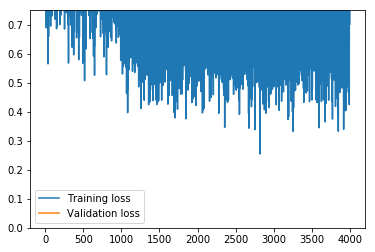

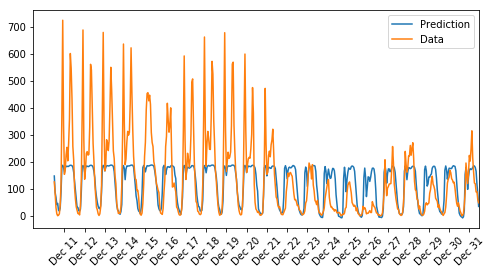

In [35]:
hyperparameter = {'learning_rate': 0.5, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 128}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).double(), torch.tensor(targets_test.values).double())

Result looks not similar to the model build in the udacity project.

In [0]:
# try other hyperparameter
hyperparameter = {'learning_rate': 0.01, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 128}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).double(), torch.tensor(targets_test.values).double())

## Hyperparamter tuning with tune

In [37]:
pip install --upgrade git+git://github.com/hyperopt/hyperopt.git

  Cloning git://github.com/hyperopt/hyperopt.git to /tmp/pip-req-build-n76wonkz
  Running command git clone -q git://github.com/hyperopt/hyperopt.git /tmp/pip-req-build-n76wonkz
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 1.7MB 6.6MB/s 
  Created wheel for hyperopt: filename=hyperopt-0.1.2-cp36-none-any.whl size=115643 sha256=61e115e0795af03f1d529291953940988e93304c567ffedf81cba5b28f159312
  Stored in directory: /tmp/pip-ephem-wheel-cache-l892bh4k/wheels/c9/13/71/0d7783dc440af384cb42aff4d1f3b1ca565115fcda10588c9c
  Created wheel for networkx: filename=networkx-2.2-py2.py3-none-any.whl size=1527322 sha256=e19ec0b57d7970a46f2bd053776edd71578ab1dcad29c7a78354a85024266726
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built hyperopt networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  F

In [51]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp, tpe

def tune_it(config):
  train_validate_with_tune_tracking(train_set, valid_set, config, with_tune_tracking=True)

search_space = { 'learning_rate': hp.uniform('learning_rate', 0.1, 1.0),
         'hidden_nodes': hp.choice('hidden_nodes', [10, 25, 30]),
         'batch_size': hp.choice('batch_size', [128, 1])
}

current_best_params = [{ 'learning_rate': 0.5,
                        'hidden_nodes': 1, # index hidden nodes 25
                        'batch_size': 0 # index of batch size 128
                        }]

hyperopt = HyperOptSearch(search_space,
                          metric="validation_loss_metric",
                          mode="min",
                          points_to_evaluate=current_best_params)

tune_result = tune.run(tune_it,
                   config={'epochs': 10,#4000,
                           },
                   local_dir='tune_logs',
                   verbose=2,
                   resources_per_trial={"cpu": 2, "gpu": 1},
                   search_alg=hyperopt
                   )

2019-09-05 22:23:00,029	INFO function_runner.py:249 -- tune.track signature detected.
2019-09-05 22:23:00,072	INFO trial_runner.py:176 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs
Memory usage on this node: 2.3/13.7 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/2 CPUs, 1/1 GPUs
Memory usage on this node: 2.3/13.7 GB
Result logdir: tune_logs/tune_it
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - tune_it_1_batch_size=128,epochs=10,hidden_nodes=25,learning_rate=0.5:	RUNNING

Result for tune_it_1_batch_size=128,epochs=10,hidden_nodes=25,learning_rate=0.5:
  date: 2019-09-05_22-23-04
  done: false
  experiment_id: a4b073ea437a442ab1dc3bc5ba2a7178
  hostname: a100d39a5c1d
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 3931
  time_since_restore: 2.605412244796753
  time_this_iter_s: 2.605412244796753
  time_total_s: 2.605412244796753
  timestamp: 1567722184
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: b80183b8
  validation_loss_metric: 4.232953193271678
  
== Status ==
Using FIFO scheduling algorithm.
Resources reques

In [50]:
print("Best config: ", tune_result.get_best_config(metric='validation_loss_metric'))

Best config:  {'batch_size': 128, 'epochs': 10, 'hidden_nodes': 25, 'learning_rate': 0.5}


In [0]:
%load_ext tensorboard
%tensorboard --logdir tune_logs/tune_it

## Further steps/TODO

- test with adding field *workingday*
- test with making field *holiday* categorical
- test with delete field *year*
- test with adding field *atemp*


- check standard deviation
- drop header in data
- add dropout


- losses of this model differ from losses of original implementation with same hyperparameter


- change tune from grid search to bayesian optimization and write comments
- try different bag sizes for test/validation/train sets
- build fcn best practice by Andrej Karpathy

- save best model
- access best metric value from tune result
- use tpe in hyperopt

- hand different optimizer and model over to tune

- log multiple metrices at once